In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import os
from PIL import Image

# set up data

In [2]:
def is_scan(filename):
    return any(filename.endswith(ext) for ext in ['.bin'])
def is_label(filename):
    return any(filename.endswith(ext) for ext in ['.label'])
def is_rgb(filename):
    return any(filename.endswith(ext) for ext in ['.png'])

scan_path = os.path.join("/DATACENTER2/yau-project/dataset/sequences/00/velodyne")
label_path = os.path.join("/DATACENTER2/yau-project/dataset/sequences/00/labels")
rgb_path = os.path.join("/DATACENTER2/yau-project/dataset/sequences/00/image_2")

scan_files = [os.path.join(dp, f) for dp, dn, fn in os.walk(
    os.path.expanduser(scan_path)) for f in fn if is_scan(f)]
label_files = [os.path.join(dp, f) for dp, dn, fn in os.walk(
    os.path.expanduser(label_path)) for f in fn if is_label(f)]
rgb_files = [os.path.join(dp, f) for dp, dn, fn in os.walk(
    os.path.expanduser(rgb_path)) for f in fn if is_rgb(f)]

scan_files.sort()
label_files.sort()
rgb_files.sort()

# metadata
fov_up = 3.0 / 180.0 * np.pi
fov_down = 25.0 / 180.0 * np.pi
fov = fov_down + fov_up
proj_H, proj_W = 64, 2048

# Missing & covered point statistics
*Missing point*: the **pixel** $(r, c)$ on the range image which no lidar points were projected onto

*Covered point*: the **lidar point** $(x, y, z)$ which was covered by another lidar point projected to the same pixel in the range image

$$\text{Missing %} = \frac{\text{missingPoint}}{W \times H}$$

$$\text{Covered %} = \frac{\text{coveredPoint}}{\text{totalPoint}}$$

## Result
$$\text{Missing point} = 36191641$$
$$\text{Covered point} = 27932231$$
$$\text{Total point} = 140540078$$
$$\text{Missing %} = 24.323440 \%$$
$$\text{Covered %} = 19.878103 \%$$

# Covered point error estimation
$$\text{wrong count} = 3329974$$  
$$\text{covered count} = 27932231$$
$$\text{total count} = 140540078$$
$$\text{% of covered point wrongly classified} = 11.923046\%$$
$$\text{performance drawback} = \frac{wrongCount}{totalPoint} = 2.369\%$$

In [ ]:
coveredCount, wrongCount, total = 0, 0, 0
missingCount = 0

for i in range(len(scan_files)):
    
#     i = 1200 # debug
    
    scan = np.fromfile(scan_files[i], dtype=np.float32)
    scan = scan.reshape((-1, 4))
    raw_label = np.fromfile(label_files[i], dtype=np.int32)
    raw_label = raw_label.reshape((-1))
    
    scan_x, scan_y, scan_z, remission = scan[:, 0], scan[:, 1], scan[:, 2], scan[:, 3]
    points = scan[:, :3]
    depth = np.linalg.norm(scan[:, :3], 2, axis=1)
    labels = raw_label

    # get angles of all points
    yaw = -np.arctan2(scan_y, scan_x)
    pitch = np.arcsin(scan_z / depth)

    # get projections in image coords
    proj_x = 0.5 * (yaw / np.pi + 1.0)          # in [0.0, 1.0]
    proj_y = 1.0 - (pitch + fov_down) / fov        # in [0.0, 1.0]

    # scale to image size using angular resolution
    proj_x *= proj_W                              # in [0.0, W]
    proj_y *= proj_H                              # in [0.0, H]

    # round and clamp for use as index
    proj_x = np.floor(proj_x)
    proj_x = np.minimum(proj_W - 1, proj_x)
    proj_x = np.maximum(0, proj_x).astype(np.int32)   # in [0,W-1]

    proj_y = np.floor(proj_y)
    proj_y = np.minimum(proj_H - 1, proj_y)
    proj_y = np.maximum(0, proj_y).astype(np.int32)   # in [0,H-1]

    # order in decreasing depth
    indices = np.arange(depth.shape[0])
    order = np.argsort(depth)[::-1]
    depth = depth[order]
    indices = indices[order]
    points = points[order]
    remission = remission[order]
    proj_y = proj_y[order]
    proj_x = proj_x[order]
    labels = labels[order]

    # assign to images
    proj_range = np.full((proj_H, proj_W), -1, dtype=np.float32)
    proj_xyz = np.full((proj_H, proj_W, 3), -1, dtype=np.float32)
    proj_remission = np.full((proj_H, proj_W), -1, dtype=np.float32)
    proj_idx = np.full((proj_H, proj_W), -1, dtype=np.int32) # -1 means no data
    proj_label = np.zeros((proj_H, proj_W), dtype=np.int32)
    proj_mask = np.zeros((proj_H, proj_W), dtype=np.int32) # 0 means no data

    proj_range[proj_y, proj_x] = depth
    proj_xyz[proj_y, proj_x] = points
    proj_remission[proj_y, proj_x] = remission
    proj_idx[proj_y, proj_x] = indices
    proj_label[proj_y, proj_x] = labels
    proj_mask = (proj_idx > 0).astype(np.int32)

    # crop to 64 * 512
    proj_range = proj_range[:, 768:1280]
    proj_xyz = proj_xyz[:, 768:1280]
    proj_remission = proj_remission[:, 768:1280]
    proj_idx = proj_idx[:, 768:1280]
    proj_label = proj_label[:, 768:1280]
    proj_mask = proj_mask[:, 768:1280]

    # statistic
    filled = fill_missing_points(torch.tensor(proj_range), torch.tensor(proj_mask, dtype=torch.bool)).numpy()
    missingCount += np.sum(np.abs(filled) < 1e6)
#     crop = np.logical_and(768 <= proj_x, proj_x < 1280)
#     total += np.sum(crop)
#     covered = np.logical_and(crop, proj_idx[proj_y, proj_x] != indices)
#     wrongCount += np.sum(proj_label[proj_y[covered], proj_x[covered]] != labels[covered])
#     coveredCount += np.sum(covered)
    
#     break # debug
    
    if i % 200 == 199:
        print(f"{i + 1} / {len(scan_files)}, missing: {missingCount}")
#         print(f"Wrong: {wrongCount}, Covered: {coveredCount}, Total: {total}, Performance drawbacks: {wrongCount / total:%}")
        

200 / 4541, missing: 6553600
400 / 4541, missing: 13107200
600 / 4541, missing: 19660800
800 / 4541, missing: 26214400
1000 / 4541, missing: 32768000
1200 / 4541, missing: 39321600
1400 / 4541, missing: 45875200
1600 / 4541, missing: 52428800
1800 / 4541, missing: 58982400
2000 / 4541, missing: 65536000
2200 / 4541, missing: 72089600
2400 / 4541, missing: 78643200
2600 / 4541, missing: 85196800
2800 / 4541, missing: 91750400
3000 / 4541, missing: 98304000
3200 / 4541, missing: 104857600


In [21]:
np.sum(np.abs(np.random.randn(5, 5)) < 0.5)

11

# Visual analysis

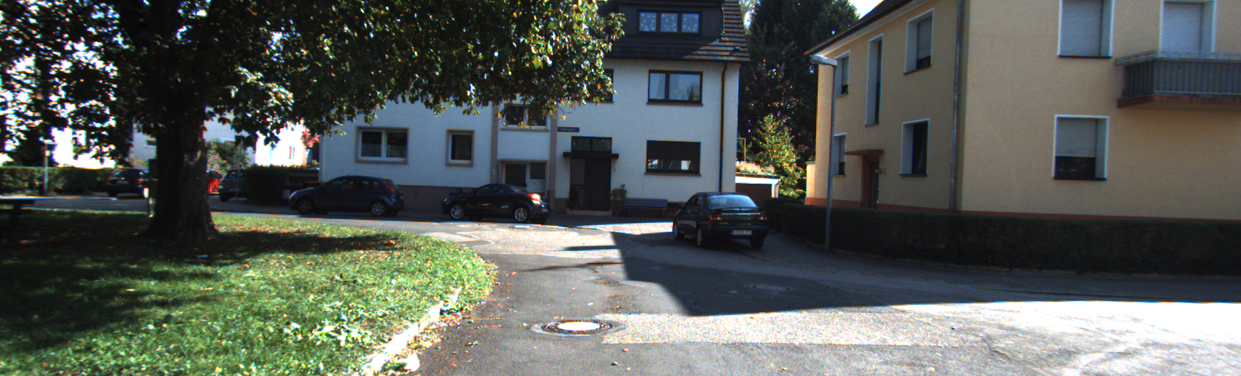

In [4]:
from IPython.display import Image as IPythonImage
IPythonImage(filename=rgb_files[1200])

# Mid-point Filter
Dealing with missing points (dropout noise)  
中值滤波可以解决 salt-and-pepper noise, 但上下部分的大片 missing 区域怎么解决?

In [8]:
class MedianPool2d(nn.Module):
    """ Median pool (usable as median filter when stride=1) module.
    Args:
         kernel_size: size of pooling kernel, int or 2-tuple
         stride: pool stride, int or 2-tuple
         padding: pool padding, int or 4-tuple (l, r, t, b) as in pytorch F.pad
         same: override padding and enforce same padding, boolean
    """
    def __init__(self, kernel_size=3, stride=1, padding=0, same=True):
        super(MedianPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding
    
    def forward(self, x):
        # using existing pytorch functions and tensor ops so that we get autograd, 
        # would likely be more efficient to implement from scratch at C/Cuda level
        x = F.pad(x, self._padding(x), mode='reflect')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        return x

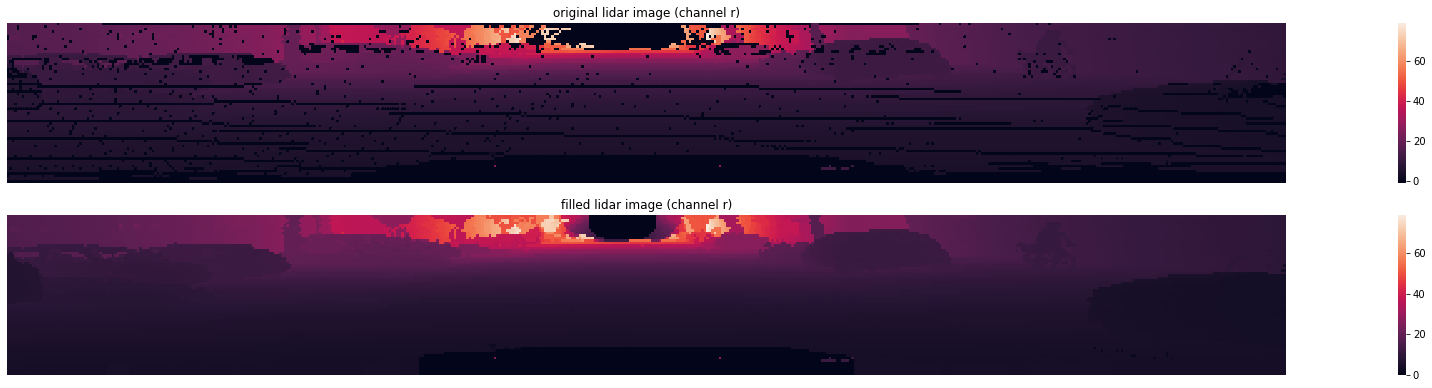

In [9]:
medpool3 = MedianPool2d()
medpool5 = MedianPool2d(kernel_size=5)
medpool7 = MedianPool2d(kernel_size=7)
medpool13 = MedianPool2d(kernel_size=13)
medpool29 = MedianPool2d(kernel_size=29)

def fill_missing_points(tensor, mask):
    """
    Fill missing points in `tensor` indicated by `mask`
    Args:
        tensor: any H * W tensor
        mask: boolean mask where `False` indicates missing points
    Returns:
        median: filled tensor
    """
    # TODO: deal with outliers using low pass filters: https://www.tutorialspoint.com/dip/high_pass_vs_low_pass_filters.htm
    eps = 1e-6
    H, W = tensor.shape[0], tensor.shape[1]
    tensor = tensor * mask # clear the tensor
    
    # repeatedly apply median filter
    median = tensor.clone()
    medpools = [medpool3, medpool5, medpool7, medpool13, medpool29]
    for medpool in medpools:
        median = median + medpool(median.unsqueeze(0).unsqueeze(0)).squeeze() * torch.logical_not(mask)
        mask = median.abs() > eps

#     # fill the top and bottom part
#     # upperhalf: maximum
#     mask_top = torch.cat([mask[:H//2], torch.full((H//2, W), True, dtype=bool, device=device)])
#     maximum = torch.max(median.masked_select(mask_top))
#     median.masked_fill_(torch.logical_not(mask_top), maximum)
#     # lowerhalf: minimum
#     mask_bottom = torch.cat([torch.full((H//2, W), True, dtype=bool, device=device), mask[H//2:]])
#     minimum = torch.min(median.masked_select(mask_bottom))
#     median.masked_fill_(torch.logical_not(mask_bottom), minimum)
    return median

plt.figure(figsize=(40, 10))
proj_range_filled = fill_missing_points(torch.tensor(proj_range), torch.tensor(proj_mask, dtype=torch.bool))

# plot
plt.subplot(3, 1, 1)
plt.title("original lidar image (channel r)")
plt.axis("off")
sns.heatmap(proj_range, square=True)
plt.subplot(3, 1, 2)
plt.title("filled lidar image (channel r)")
plt.axis("off")
sns.heatmap(proj_range_filled, square=True)

# Range image -> RGB

In [38]:
def project_range_to_rgb(range_img, calib):
    """
    Project range image to RGB image
    Args:
        range_img: ch * H * W tensor, channel = [range, x, y, z, remission, proj_mask] (all r should be filled)
        calib: preprocessed calibration `dict`, with fields "Tr" and "P2"
    Returns:
        flow: data from from RGB image to range image
    """
    xyz = range_img[:3, :, :] # workaround
    
    # P0: left grayscale, P1: right grayscale, P2: left color, P3: right color
    Tr = np.concatenate((calib['Tr'], np.array([[0., 0., 0., 1.]])))
    P2 = calib['P2']
    calib_matrix = np.dot(P2, Tr)
    
    xyz = xyz.reshape(3, -1) # flatten
    rgb_idx = np.dot(calib_matrix, np.concatenate((xyz, np.ones((1, xyz.shape[1])))))
    rgb_idx[:2, :] /= rgb_idx[2, :] # normalize
    rgb_idx = rgb_idx[:2, :] # discard useless dim
    rgb_idx = rgb_idx.reshape(2, 64, 512) # unflatten
    
    flow = rgb_idx.round().astype(np.int)
    
    return flow

###########################
# test
###########################
raw_xyz = proj_xyz.transpose((2, 0, 1))
range_img = torch.stack([fill_missing_points(torch.tensor(raw_xyz[i]), torch.tensor(proj_mask, dtype=torch.bool)) for i in range(3)], dim=0)
print(range_img.shape)

## calibration matrix from kitti-odometry / semantic-kitti
calib = {}
with open("/DATACENTER2/yau-project/dataset/sequences/00/calib.txt", 'r') as file:
    for line in file.readlines():
        key, value = line.split(":", 1)
        value = np.array(value.split(), dtype=np.float).reshape(3, 4)
        calib[key] = value

flow = project_range_to_rgb(range_img, calib)
print(flow.shape)

torch.Size([3, 64, 512])
(2, 64, 512)


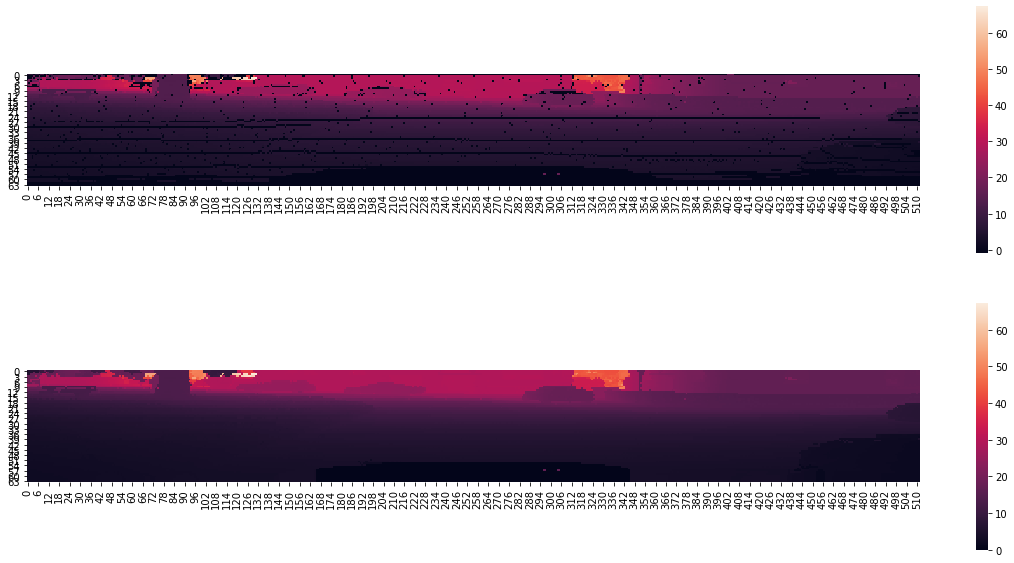

In [39]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
sns.heatmap(raw_xyz[0], square=True)
plt.subplot(2, 1, 2)
sns.heatmap(range_img[0], square=True)

(376, 1241, 3)


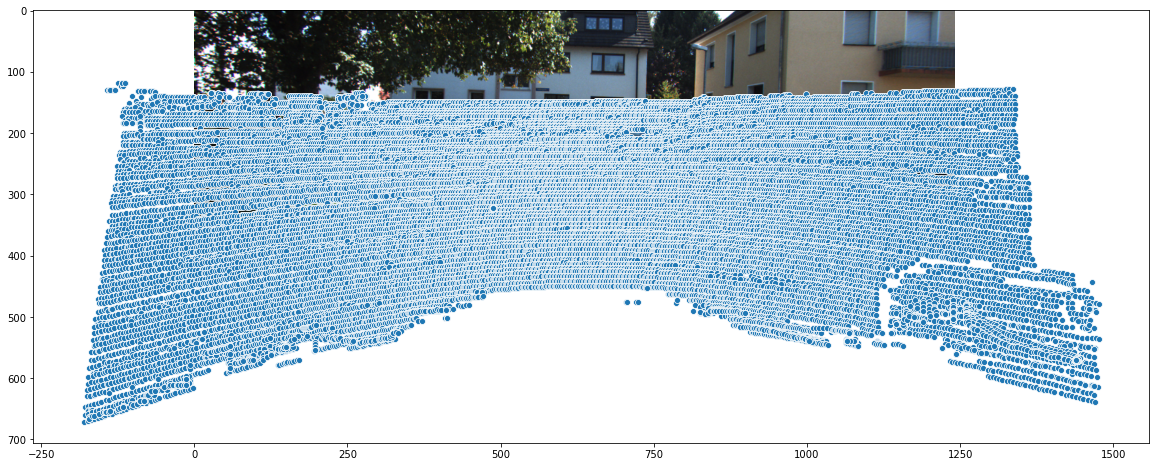

In [43]:
img = np.array(Image.open(rgb_files[1200]))
print(img.shape)
plt.figure(figsize=(20, 10))
sns.scatterplot(x=flow[0, ...].flatten(), y=flow[1, ...].flatten())
plt.imshow(img)

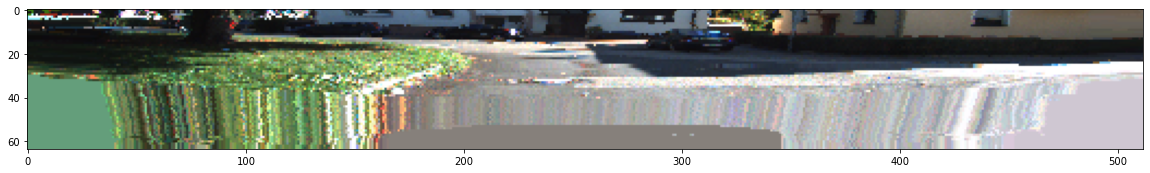

In [44]:
feature = img[flow[1, ...].flatten().clip(0, 375), flow[0, ...].flatten().clip(0, 1240)].reshape(64, 512, 3)
plt.figure(figsize=(20, 10))
plt.imshow(feature)
# TODO: take the mean rgb value og the pixel area

# Obsolete: don't run!!

# Obsolete: don't run!!

# Obsolete: don't run!!

# Obsolete: don't run!!

# Obsolete: don't run!!

# Obsolete: don't run!!

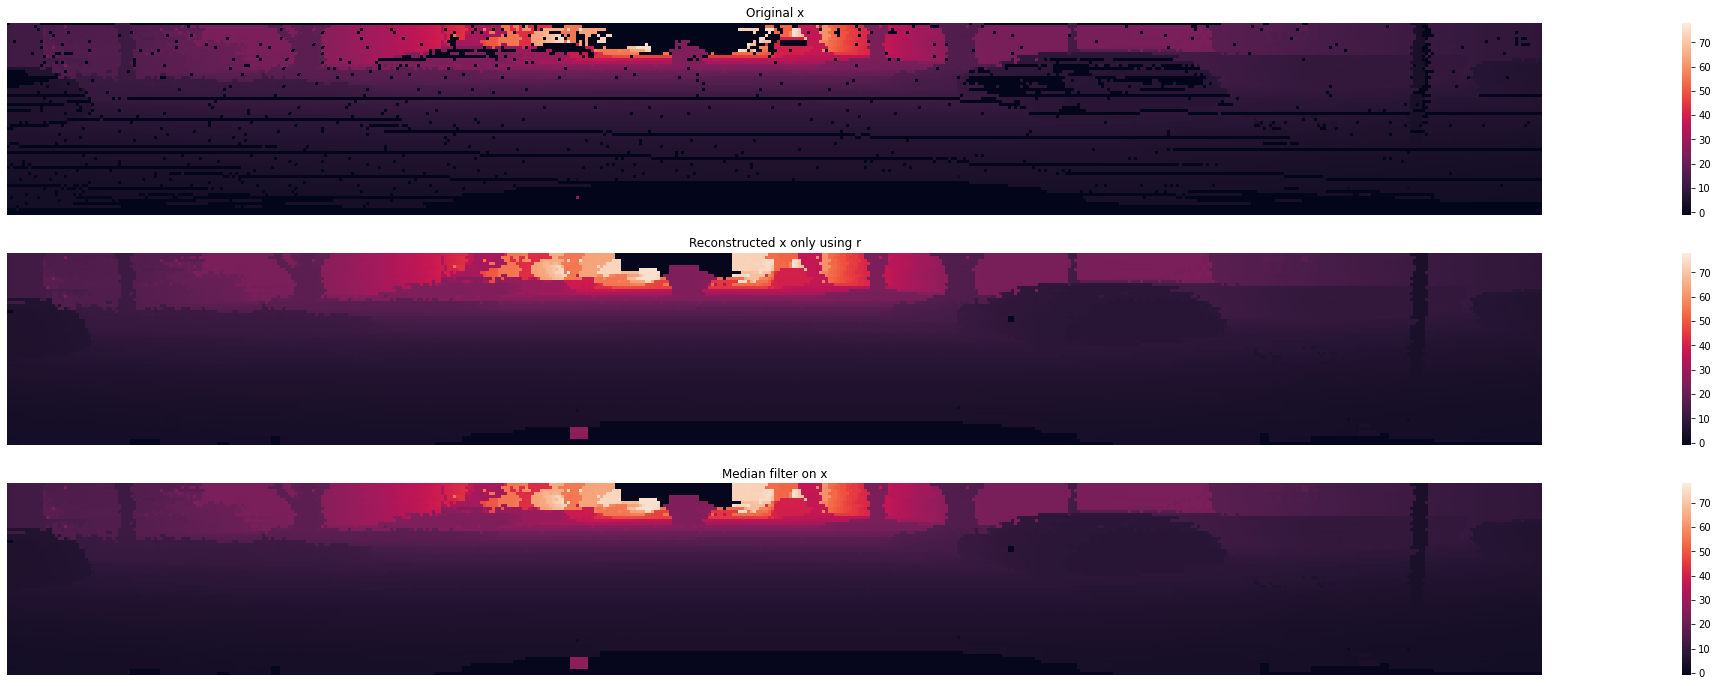

In [88]:
plot_idx = 0 # 0-2
names = ("x", "y", "z")
plt.figure(figsize=(50, 12))
plt.subplot(3, 1, 1)
plt.axis('off')
plt.title(f"Original {names[plot_idx]}")
sns.heatmap(range_img[plot_idx + 1], square=True)
plt.subplot(3, 1, 2)
plt.axis('off')
plt.title(f"Reconstructed {names[plot_idx]} only using r")
sns.heatmap(xyz.reshape((3, 64, 512))[plot_idx], square=True, vmin=np.min(range_img[plot_idx+1]), vmax=np.max(range_img[plot_idx+1]))
plt.subplot(3, 1, 3)
plt.axis('off')
plt.title(f"Median filter on {names[plot_idx]}")
temp = apply_filter(torch.tensor(range_img[plot_idx + 1]), torch.tensor(proj_mask, dtype=torch.bool))
filtered = range_img[plot_idx + 1] * proj_mask + temp.numpy() * np.logical_not(proj_mask)
sns.heatmap(filtered, square=True, vmin=np.min(range_img[plot_idx+1]), vmax=np.max(range_img[plot_idx+1]))

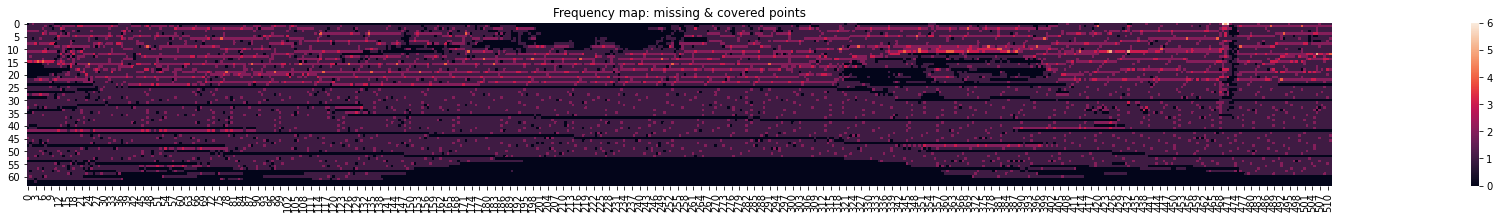

In [14]:
frequency = np.zeros((proj_H, proj_W), dtype=np.int32)
for y, x in zip(proj_y, proj_x):
    frequency[y, x] += 1
frequency = frequency[:, 768:1280]
plt.figure(figsize=(50, 3))
sns.heatmap(frequency, square=True)
_ = plt.title("Frequency map: missing & covered points")

(3, 124668)
(3, 3220)


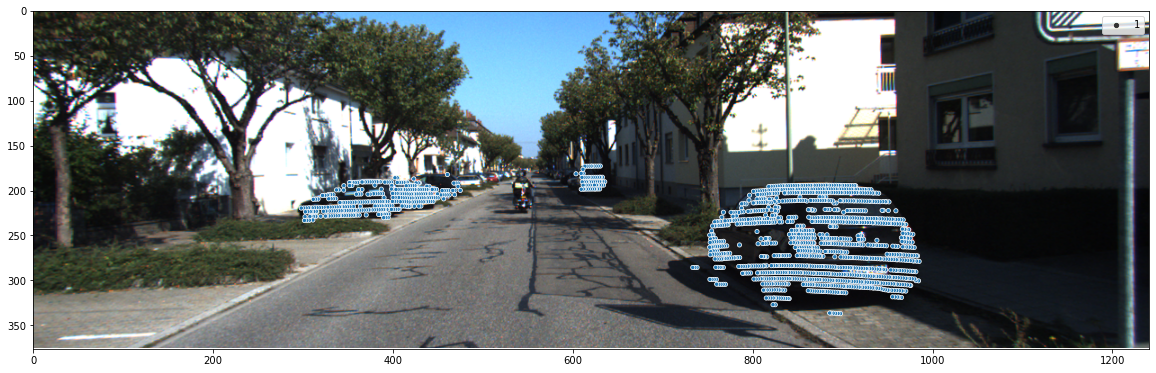

In [13]:
# old code
scan = np.fromfile(scan_files[0], dtype=np.float32).reshape(-1, 4)
xyz = scan[:, :3].T
label = np.fromfile(label_files[0], dtype=np.uint32).reshape(-1)
label = label & 0xFFFF # semantic label
data_cfg = yaml.safe_load(open("./yaumodel/data_cfg.yaml", 'r'))
for i, _ in enumerate(label):
    label[i] = data_cfg['learning_map'][label[i]]

calib = {}
## calibration matrix from kitti-odometry / semantic-kitti
with open("/DATACENTER2/yau-project/dataset/sequences/00/calib.txt", 'r') as file:
    for line in file.readlines():
        key, value = line.split(":", 1)
        value = np.array(value.split(), dtype=np.float).reshape(3, 4)
        calib[key] = value

Tr = np.concatenate((calib['Tr'], np.array([[0, 0, 0, 1]])), axis=0)

# P0: left grayscale, P1: right grayscale, P2: left color, P3: right color
P2 = calib['P2']

rc = np.matmul(np.matmul(P2, Tr), np.concatenate((xyz, np.ones((1, xyz.shape[1]))), axis=0))
rc[:2, :] /= rc[2, :]

mask = np.logical_and(label == 1, rc[2, :] > 0)
print(rc.shape)
rc = rc[:, mask] # mask out background
print(rc.shape)

plt.figure(figsize=(20, 10))
plt.xlim(0, 1241)
plt.ylim(376, 0)
sns.scatterplot(x=rc[0, :], y=rc[1, :], size=1)

img = Image.open(rgb_files[0])
plt.imshow(img)